In [1]:
from __future__ import annotations

import pickle

import numpy as np
from mpi4py import MPI
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.block_tridiag import greenfunction
from qtpyt.parallel import comm
from qtpyt.parallel.egrid import GridDesc
from qtpyt.projector import expand

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

[anooja-ThinkPad-X1-Carbon-Gen-11:24272] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [2]:
class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_molecule_identity, super().retarded(energy), idx_molecule)


def load(filename):
    return DataSelfEnergy(energies, np.load(filename))


def run(outputfile):
    gd = GridDesc(energies, 1, float)
    T = np.empty(gd.energies.size)
    for e, energy in enumerate(gd.energies):
        T[e] = gf.get_transmission(energy, ferretti=True)

    T = gd.gather_energies(T)

    if comm.rank == 0:
        np.save(outputfile, (energies, T.real))

In [3]:
data_folder = "../output/lowdin"
output_folder = "../output/lowdin/ferretti"
dmft_data_folder = "../output/lowdin/beta_38.68/dmft/no_spin"
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
self_energy = np.load(f"{data_folder}/self_energy.npy", allow_pickle=True)
dmft_sigma_file = f"{dmft_data_folder}/dmft_sigma.npy"

de = 0.01
energies = np.arange(-3, 3 + de / 2.0, de).round(7)
eta = 1e-3

with open(f"{data_folder}/hs_list_ii.pkl", "rb") as f:
    hs_list_ii = pickle.load(f)
with open(f"{data_folder}/hs_list_ij.pkl", "rb") as f:
    hs_list_ij = pickle.load(f)

nodes = [0, 810, 1116, 1252, 1558, 2368]

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [(0, self_energy[0]), (len(hs_list_ii) - 1, self_energy[1])],
    solver="dyson",
    eta=eta,
)


In [4]:
# Add the DMFT self-energy for transmission
if comm.rank == 0:
    dmft_sigma = load(dmft_sigma_file)
else:
    dmft_sigma = None

# Transmission function calculation
imb = 2  # index of molecule block from the nodes list
S_molecule = hs_list_ii[imb][1]  # overlap of molecule
S_molecule_identity = np.eye(S_molecule.shape[0])
idx_molecule = (
    index_active_region - nodes[imb]
)  # indices of active region w.r.t molecule

dmft_sigma = comm.bcast(dmft_sigma, root=0)
self_energy[2] = dmft_sigma
gf.selfenergies.append((imb, self_energy[2]))

In [5]:
idx_molecule

array([  3,  31,  44,  67,  80, 103, 116])

In [6]:
test = self_energy[2].retarded(0.25)

# Flatten the array and find the indices of the largest 10 values
flat_indices = np.argpartition(test.real.ravel(), -10)[-10:]

# Convert flat indices back to 2D indices
indices = np.unravel_index(flat_indices, test.real.shape)

# Get the corresponding values
values = test.real[indices]

# Sort the values and indices in descending order
sorted_indices = np.argsort(values)[::-1]
top_values = values[sorted_indices]
top_indices = tuple(idx[sorted_indices] for idx in indices)

# Print the values and their positions
for value, index in zip(top_values, zip(*top_indices)):
    print(f"Value: {value}, Index: {index}")


Value: 26.571038236277552, Index: (67, 67)
Value: 0.4678530714323319, Index: (44, 44)
Value: 0.4605287458198566, Index: (80, 80)
Value: 0.10051153052982342, Index: (31, 31)
Value: 0.021314905018545716, Index: (103, 103)
Value: 0.0, Index: (45, 43)
Value: 0.0, Index: (45, 45)
Value: 0.0, Index: (45, 42)
Value: 0.0, Index: (45, 44)
Value: 0.0, Index: (135, 135)


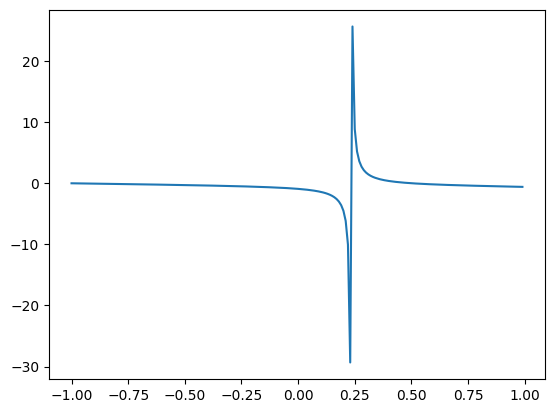

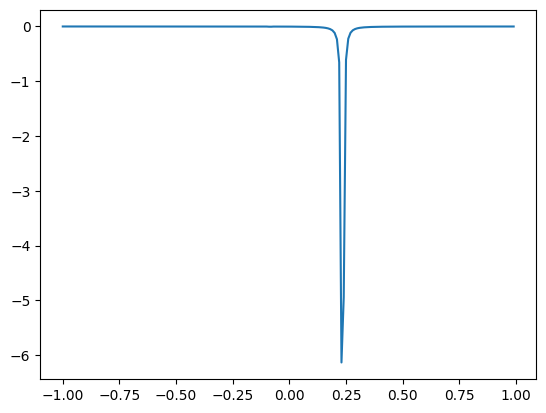

In [7]:
import matplotlib.pyplot as plt

energies2 = np.arange(-1,1,0.01)
se = np.array([self_energy[2].retarded(e) for e in energies2])
trace_sigma = np.trace(se, axis1=1, axis2=2)
plt.plot(energies2, trace_sigma.real)
plt.show()
plt.plot(energies2, trace_sigma.imag)
plt.show()

In [8]:
outputfile = f"{output_folder}/dmft_transmission_btm_ferretti_correction.npy"
run(outputfile)
gf.selfenergies.pop()

Ferretti correction
(810, 306) (810, 306) (306, 136) (306, 136)
Ferretti correction
(810, 306) (810, 306) (306, 136) (306, 136)
Ferretti correction
(810, 306) (810, 306) (306, 136) (306, 136)
Ferretti correction
(810, 306) (810, 306) (306, 136) (306, 136)
Ferretti correction
(810, 306) (810, 306) (306, 136) (306, 136)


KeyboardInterrupt: 

In [34]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Define dimensions for the lead and bridge subspaces
dim_lead = 6
dim_bridge = 10

# Random coupling matrices for left and right leads
V_L = np.random.rand(dim_lead, dim_bridge) + 1j * np.random.rand(dim_lead, dim_bridge)
V_R = np.random.rand(dim_lead, dim_bridge) + 1j * np.random.rand(dim_lead, dim_bridge)

# Random correlation term (delta) in the bridge subspace
delta = np.random.rand(dim_bridge, dim_bridge) + 1j * np.random.rand(dim_bridge, dim_bridge)

# Project the correction term into both left and right lead subspaces
Gamma_corr = V_L @ delta @ V_L.conj().T + V_R @ delta @ V_R.conj().T

# Display the result
print("Projected Gamma_corr (including both leads):")
print(Gamma_corr)
print(Gamma_corr.shape)

Projected Gamma_corr (including both leads):
[[51.08092482+51.38794547j 57.74205433+43.95153659j
  43.87087565+37.06745769j 52.97822921+49.89244364j
  48.30411191+43.55049867j 55.43335242+49.85365332j]
 [46.99162217+58.40375855j 54.26322411+54.29372586j
  39.55697923+41.89919288j 47.20394395+56.26171257j
  41.79498404+47.28713209j 49.59460574+58.11849063j]
 [41.86940224+42.48815479j 47.11969346+35.73280955j
  38.40492801+34.13441119j 43.45088217+43.04666038j
  38.52047896+35.98036914j 46.29932755+44.39158623j]
 [52.65119397+49.46822386j 61.10481999+44.40952034j
  44.63807322+35.96859724j 53.44191913+51.96832805j
  47.17798037+42.77725216j 57.65449019+50.36587799j]
 [42.32891262+45.64381361j 49.73080051+39.59207478j
  36.15021067+34.42451374j 43.49725439+46.88934619j
  38.8065677 +38.87409646j 46.69704571+46.8806785j ]
 [54.34745015+52.14769175j 61.94074491+45.23726774j
  47.9985868 +39.58375808j 53.93071865+52.67130909j
  48.97942357+45.31171755j 60.8607173 +54.09250439j]]
(6, 6)
